# Load Package & Config ini

In [7]:
#configparser
import configparser
global HOST,PORT,DB_ID,DB_PW,MODEL_DIR,MODEL_NAME
conf_dir = '/home/cdsadmin/python_src/EY/Emart/conf/config.ini'
cfg = configparser.ConfigParser(interpolation=configparser.ExtendedInterpolation())
cfg.read(conf_dir)
# default package 
import numpy as np
import pandas as pd 
import time,os,psutil
import IPython
from datetime import datetime
from IPython.lib import kernel
import collections
import itertools
import pickle,ast,joblib
## hana DB client 
from hdbcli import dbapi 
from IPython.core.display import display, Image
import multiprocessing
import sqlite3

#visualization 
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.metrics import plot_confusion_matrix

from collections import Counter

# feature selection 
from sklearn.feature_selection import SelectFromModel
from sklearn.inspection import permutation_importance

# split data & sampling for imbalanced set
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from multi_imbalance.utils.min_int_maj import maj_int_min

# predict model
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from vecstack import stacking
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost  import XGBClassifier,XGBRFClassifier
from sklearn.linear_model import LinearRegression,Ridge,Lasso

#confusion matrix (measure)
from sklearn.metrics import confusion_matrix,precision_score,recall_score,\
                              f1_score,accuracy_score,roc_auc_score,roc_curve,auc,\
                              classification_report,precision_recall_curve
from sklearn.model_selection import cross_val_score,KFold
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

#--------------------------------------------------------
# ■ setting configuration (db_connectionm, load_model)
#--------------------------------------------------------
HOST  = cfg['dbconnect']['host']
PORT  = int(cfg['dbconnect']['port'])
DB_ID = cfg['dbconnect']['ID']
DB_PW = cfg['dbconnect']['PW']
MODEL_DIR  = cfg['Mollys']['MODEL_DIR']
# MODEL_NAME = cfg['Mollys']['MODEL_NAME']

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 90)
pd.set_option('display.width', 1000)
pd.set_option('mode.chained_assignment',  None) # <==== turn off warining message 

['/home/cdsadmin/python_src/EY/Emart/conf/config.ini']

# MultiProcessing

In [8]:
# %load ./multiprocessing_sequence.py
## --------------------------------------------------
## load_data
## --------------------------------------------------
## multiprocessing 준비

def check_pid():
    connection_file_path = kernel.get_connection_file()
    connection_file      = os.path.basename(connection_file_path)
    kernel_id            = connection_file.split('-', 1)[1].split('.')[0]
    print('■ [PID]          : %s '%os.getpid())
    print('■ [Jupyter path] : %s' %os.getcwd())
    print('■ [Kernel ID]    : %s' %kernel_id)

def timecheck(start):
    learn_time = time.time() - start
    train_time = round(learn_time/60)  
    print("소요시간 :",  round(learn_time,-1), "초", "  (",train_time, "분 )\n")
    return learn_time,train_time
    
def DB_Connection() :
    conn=dbapi.connect(HOST,PORT,DB_ID,DB_PW)
    return conn

def Datachunk_range(rownum_sql) :
    conn = DB_Connection()
    cnt  = pd.read_sql(rownum_sql, conn)
    key  = int(cnt.values)
    print('Data  count : %s'%key)
    rm   = key % n_core
    ## Split row_num / n_core 
    arg_list_flt =[i for i in range(0,key,int(key/n_core))]
    ## last sequence add remainder 
    if rm > 0:
        arg_list_flt[len(arg_list_flt)-1] = arg_list_flt[len(arg_list_flt)-1]+rm
    else:
        arg_list_flt.append(arg_list_flt[-1]+arg_list_flt[1])
    conn.close()        
    return arg_list_flt,rm

def SQL_worker(num):    
    b = int(arg_list.index(num))-1
    if (int(arg_list.index(num)) == 0) :
        result = None
    else :
        start_num = int(arg_list[b])+1
        end_num   = int(num)
        print('start_num : %s | end_num : %s'%(start_num,end_num))
        sql =f'''
                SELECT *
                FROM (SELECT   ROW_NUMBER() OVER (ORDER BY CUST_ID ASC) AS ROW_NUM
                             , *
                      FROM  {db_name}) T1
                WHERE T1.ROW_NUM between {start_num} and {end_num}
              '''
        conn = DB_Connection()
        result = pd.read_sql(sql, conn)
        conn.close()
    return result

def multiprocesser(arg_list) : 
    check_pid()
    print('\nstart_arg_list : %s \n'%arg_list)
    p = multiprocessing.Pool(processes = n_core)
    data = p.map(SQL_worker, arg_list) 
    p.close()
    p.join()
    result = pd.concat(data)
    return result   

def check_cpu_percent(num):
    cpu_cnt = len(psutil.Process().cpu_affinity())
    c_list = psutil.cpu_percent(percpu=True)
    available_cpu_cnt = len([i for i in c_list if i < 1])
    n_core = np.trunc(available_cpu_cnt/num)
    print('[ total_cpu_cnt ] : ',cpu_cnt)
    print('[ available_cpu_cnt ] : ',available_cpu_cnt)
    return int(n_core)


# Feature sclicing (PART2)

In [9]:
def part2_feature_select():
    Y_label =  'DOG_PREMIUM_FOOD_YN'
    key_feature = ['ROW_NUM','CUST_ID']
    x_feature = ['TOT_G_FOOD_FREQ_CNT'
                 ,'TOT_G_FOOD_SALE_AMT'
                 ,'LAST_VISIT_DATE_DIFF'
                 ,'TOT_FREQUENCY_CNT'
                 ,'TOT_RCIP_PRDT_CNT'
                 ,'TOT_PREMIUM_PRDT_CNT'
                 ,'PREMIUM_PRDT_CNT_RT'
                 ,'TOT_SALE_AMT'
                 ,'TOT_SALE_QTY'
                 ,'TOT_MCODE_CNT'
                 ,'BUY_PRDT_CD_CNT'
                 ,'RFM_LV_DI_MOLLYS'
                 ,'TOP1_STR_CD'
                 ,'TOP2_STR_CD'
                 ,'TOT_P_DCODE_2716_FREQ_CNT'
                 ,'TOT_P_DCODE_2716_QTY_SUM'
                 ,'TOT_P_DCODE_2716_AMT_SUM'
                 ,'TOT_G_DCODE_2716_AMT_SUM'
                 ,'TOT_G_DCODE_2716_FREQ_CNT'
                 ,'TOT_G_DCODE_2716_QTY_SUM'
                 ,'TOT_G_MCODE_79_FREQ_CNT'
                 ,'TOT_G_MCODE_79_QTY_SUM'
                 ,'TOT_G_MCODE_79_AMT_SUM'
                 ,'TOT_P_MCODE_79_AMT_SUM'
                 ,'TOT_P_MCODE_79_FREQ_CNT'
                 ,'TOT_P_MCODE_79_QTY_SUM'
                 ,'TOT_P_MCODE_123_FREQ_CNT'
                 ,'TOT_P_MCODE_123_QTY_SUM'
                 ,'TOT_P_MCODE_123_AMT_SUM'
                 ,'TOT_G_MCODE_123_AMT_SUM'
                 ,'TOT_G_MCODE_123_FREQ_CNT'
                 ,'TOT_G_MCODE_123_QTY_SUM'
                 ,'TOT_G_MCODE_124_FREQ_CNT'
                 ,'TOT_G_MCODE_124_QTY_SUM'
                 ,'TOT_G_MCODE_124_AMT_SUM'
                 ,'TOT_P_MCODE_124_AMT_SUM'
                 ,'TOT_P_MCODE_124_FREQ_CNT'
                 ,'TOT_P_MCODE_124_QTY_SUM'
                 ,'TOT_P_MCODE_125_FREQ_CNT'
                 ,'TOT_P_MCODE_125_QTY_SUM'
                 ,'TOT_P_MCODE_125_AMT_SUM'
                 ,'TOT_G_MCODE_125_AMT_SUM'
                 ,'TOT_G_MCODE_125_FREQ_CNT'
                 ,'TOT_G_MCODE_125_QTY_SUM'
                 ,'TOT_P_MCODE_126_FREQ_CNT'
                 ,'TOT_P_MCODE_126_QTY_SUM'
                 ,'TOT_P_MCODE_126_AMT_SUM'
                 ,'TOT_G_MCODE_126_AMT_SUM'
                 ,'TOT_G_MCODE_126_FREQ_CNT'
                 ,'TOT_G_MCODE_126_QTY_SUM'
                 ,'TOT_P_MCODE_318_FREQ_CNT'
                 ,'TOT_P_MCODE_318_QTY_SUM'
                 ,'TOT_P_MCODE_318_AMT_SUM'
                 ,'TOT_G_MCODE_318_AMT_SUM'
                 ,'TOT_G_MCODE_318_FREQ_CNT'
                 ,'TOT_G_MCODE_318_QTY_SUM'
                 ,'TOT_G_MCODE_477_FREQ_CNT'
                 ,'TOT_G_MCODE_477_QTY_SUM'
                 ,'TOT_G_MCODE_477_AMT_SUM'
                 ,'TOT_P_MCODE_477_AMT_SUM'
                 ,'TOT_P_MCODE_477_FREQ_CNT'
                 ,'TOT_P_MCODE_477_QTY_SUM'
                 ,'TOT_G_MCODE_478_FREQ_CNT'
                 ,'TOT_G_MCODE_478_QTY_SUM'
                 ,'TOT_G_MCODE_478_AMT_SUM'
                 ,'TOT_P_MCODE_478_AMT_SUM'
                 ,'TOT_P_MCODE_478_FREQ_CNT'
                 ,'TOT_P_MCODE_478_QTY_SUM'
                 ,'TOT_G_MCODE_74_FREQ_CNT'
                 ,'TOT_G_MCODE_74_QTY_SUM'
                 ,'TOT_G_MCODE_74_AMT_SUM'
                 ,'TOT_P_MCODE_74_AMT_SUM'
                 ,'TOT_P_MCODE_74_FREQ_CNT'
                 ,'TOT_P_MCODE_74_QTY_SUM'
                 ,'TOT_P_MCODE_76_FREQ_CNT'
                 ,'TOT_P_MCODE_76_QTY_SUM'
                 ,'TOT_P_MCODE_76_AMT_SUM'
                 ,'TOT_G_MCODE_76_AMT_SUM'
                 ,'TOT_G_MCODE_76_FREQ_CNT'
                 ,'TOT_G_MCODE_76_QTY_SUM'
                 ,'TOT_G_MCODE_77_FREQ_CNT'
                 ,'TOT_G_MCODE_77_QTY_SUM'
                 ,'TOT_G_MCODE_77_AMT_SUM'
                 ,'TOT_P_MCODE_77_AMT_SUM'
                 ,'TOT_P_MCODE_77_FREQ_CNT'
                 ,'TOT_P_MCODE_77_QTY_SUM']
    return Y_label,x_feature,key_feature

# Confusion Matrix & model_score 

In [10]:
def model_score(**args):
    global TN,TP,FN,FP
    global acc_s,f1_s,recall_s,precision_s,auc_score    
    global class_cat,model_key
    test_y = args['y_test']
    pred_y = args['y_pred']
    pred_y_prob = args['y_pred_prob']
    cm_matrix                = confusion_matrix(test_y,pred_y)
    TN                       = int(cm_matrix[0][0])
    FP                       = int(cm_matrix[0][1])
    FN                       = int(cm_matrix[1][0])
    TP                       = int(cm_matrix[1][1])
    FPR                      = float(1-(TN / (FP+TN)))
    acc_s                    = float(accuracy_score(test_y, pred_y))
    precision_s              = float(precision_score(test_y, pred_y))
    recall_s                 = float(recall_score(test_y, pred_y))
    f1_s                     = float(f1_score(test_y, pred_y))
    pred_target_cnt          = len(pred_y[pred_y == 1])
    pred_non_target_cnt      = len(pred_y[pred_y == 0])
    print("==============================   ACCURACY  =================================")
    print("ACCURACY : {0:.2F}%".format(acc_s))
    print("============================================================================")
    print("==============================   COUNT DATA   ==============================")
    print("test_Target_Count : %s"%(len(test_y[test_y == 1])))
    print("pred_Target_Count : %s"%(len(pred_y[pred_y == 1])))
    print("===========================   Confusion Matrix   ===========================")
    print(cm_matrix)
    print("TN : %s"% TN)
    print("TP : %s"% TP)
    print("FN : %s"% FN)
    print("FP : %s"% FP)
    print("============================================================================")
    print("=========================   Precision / Recall   ===========================")
    print("precision_rate : %.2f (TP+/TP+FP)" % precision_s)
    print("recall_rate : %.2f (TP+/TP+FN)" % recall_s)
    print("=============================   F1 SCORE   =================================")
    print("f1_score :  %.2f (2*((precision * recall)/(precision+recall)))"%f1_s)
    print("============================================================================\n\n")      
    print(classification_report(test_y, pred_y, digits=3))

# Split Train / Test

In [11]:
#Split dataset (default = train(80%),test(20%))
def split_train_test(df,size,x_feature,cat,Y_label):
    global model_input_x
    model_input_x  = x_feature
    X              = df[['ROW_NUM']+x_feature]
    X              = X.set_index(X['ROW_NUM'],inplace = False)
    X              = X[x_feature]
    Y              = df[['ROW_NUM',Y_label]]
    Y              = Y.set_index(Y['ROW_NUM'],inplace = False)
    Y              = Y[[Y_label]]
    # ■ random state = seed for shuffle
    if cat == 'random':
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y[Y_label], test_size=size, random_state=123)
    else :
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y[Y_label], test_size=size, random_state=123,stratify=Y[Y_label])        
    return X_train, X_test, Y_train, Y_test

def save_model(clf,mdl_file_nm):
    model = joblib.dump(clf,open(MODEL_DIR+mdl_file_nm+".pkl",'wb'))
    print('%s 경로에 %s 모델 저장완료 '%(MODEL_DIR,mdl_file_nm+".pkl"))
    
#save model
def load_model(filename):
    model_dir  = MODEL_DIR+filename
    load_model = joblib.load(model_dir)
    return load_model

def dict_product(param):
    return (dict(zip(param,x)) for x in itertools.product(*param.values())) 


# Hyper Parameter Estimator

In [12]:
def HyperPram_RandseachCV(X_train, Y_train,ml_cat):
    print('HyperPrameter (RandomizedSearchCV)')
    check_pid()
    start = time.time()
    if ml_cat =='xgb':
        clf = XGBClassifier()
        gridParams = {'n_estimators': [5,500],
                     'learning_rate': [0.01,0.05],
                     'subsample': [0.5,0.8],
                     'objective' : ['multi:softmax'],
                     'max_depth' : [5,20],
                     'colsample_bytree': [0.5, 0.9],
                     'min_child_weight': [1, 4]
                    }
    elif ml_cat =='lgbm':
        clf = LGBMClassifier()
        gridParams = {
                        'n_estimators': [5,500],
                        'learning_rate': [0.01,0.05],
                        'num_leaves': [50,200],
                        'boosting_type' : ['gbdt'],
                        'max_depth' : [5,40],
                        'random_state' : [123], 
                        'subsample' : [0.5,0.8],
                        'min_split_gain' : [0.01],
                        'min_data_in_leaf':[10],
                    }
    grid = RandomizedSearchCV(clf,gridParams,verbose=1,cv=5)
    grid.fit(X_train,Y_train)
    best_params = grid.best_params_
    timecheck(start)
    return best_params

# Classifier (LGBM)

In [13]:
def clf_predict(cat,X_train,X_test,Y_train,Y_test):
    print('MODEL : %s'%cat )
    print(f'Train shape : {X_train.shape}')
    print(f'Test shape : {X_test.shape}')
    print(f'Train Target :{len(Y_train[Y_train == 1])} | Non_Target : {len(Y_train[Y_train == 0])}')
    print(f'Test Target :{len(Y_test[Y_test == 1])} | Non_Target : {len(Y_test[Y_test == 0])}')

    X = X_train
    y = Y_train

    clf = LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                                       importance_type='split', learning_rate=0.01, max_depth=50,
                                       min_child_samples=20, min_child_weight=0.001,
                                       min_split_gain=0.05, n_estimators=1000, n_jobs=10,
                                       num_leaves=500, objective=None, random_state=123, reg_alpha=0.0,
                                       reg_lambda=0.0, silent=True, subsample=0.8,
                                       subsample_for_bin=200000, subsample_freq=0)
    clf.fit(X,y)
    y_pred      = clf.predict(X_test)
    y_pred_prob = clf.predict_proba(X_test)

    model_score(y_test = Y_test,y_pred = y_pred ,y_pred_prob = y_pred_prob)
    return clf

# Permutation Importance

In [14]:
def Feature_Importance(clf,df,cols,cat,Y_label,fuc):
    count_class = str(Counter(df[Y_label]))
    df     = df.fillna(0)
    X      = df[cols]
    y      = df[Y_label]
    start  = time.time()
    print('PI')
    print(count_class)
    check_pid()
    
    clf.fit(X,y)
    result     = permutation_importance(clf, X, y, n_repeats=5, random_state=42, n_jobs=10)
    sorted_idx = result.importances_mean.argsort()
    
    # visualiazation Permutation Importance
    fig, ax = plt.subplots(figsize=(20,20))
    ax.boxplot(result.importances[sorted_idx].T, vert=False, labels = X.columns[sorted_idx] )
    ax.set_title("Permutation_impotances_Test",fontsize=24)
    plt.yticks(fontsize=16)
    fig.tight_layout()
    plt.show()
    importance_t = result.importances_mean[sorted_idx]
    PI_feature = X.columns[sorted_idx]
    
    df_1 = pd.DataFrame(importance_t,PI_feature).reset_index()
    df_1.columns = ['FEATURE','IMPORTANCE']
    display(df_1.sort_values('IMPORTANCE',ascending=False))
    
    timecheck(start)
    return df_1

# Permutation Importance

In [20]:
def PermutaionImportance(clf,X_train,y_train):
    count_class = str(Counter(y_train))
    X = X_train
    y = y_train
    start = time.time()
    print('PI')
    print(count_class)
    check_pid()
    
    clf.fit(X,y)
    result     = permutation_importance(clf, X, y, n_repeats=5, random_state=42, n_jobs=10)
    sorted_idx = result.importances_mean.argsort()
    
    # visualiazation Permutation Importance
    fig, ax = plt.subplots(figsize=(20,20))
    ax.boxplot(result.importances[sorted_idx].T, vert=False, labels = X.columns[sorted_idx] )
    ax.set_title("Permutation_impotances_Test",fontsize=24)
    plt.yticks(fontsize=16)
    fig.tight_layout()
    plt.show()
    importance_t = result.importances_mean[sorted_idx]
    PI_feature = X.columns[sorted_idx]
    
    df_1 = pd.DataFrame(importance_t,PI_feature).reset_index()
    df_1.columns =  ['FEATURE_NAME','IMPORTANCE_PI']
    last_pi = df_1.sort_values('IMPORTANCE_PI',ascending=False)    

    timecheck(start)
    return last_p

# Feature Importance(GAIN)

In [15]:
def clf_feature_importance(mdl_nm):
    p_model_clf = load_model(mdl_nm)
    print(p_model_clf.feature_name_)
    mdl_fi = pd.DataFrame({'FEATURE_NAME' : p_model_clf.feature_name_,
                           'IMPORTANCE_SPLIT' : list(p_model_clf.feature_importances_),
                           'IMPORTANCE_GAIN':list(p_model_clf.booster_.feature_importance(importance_type='gain'))})

    mdl_fi['SPLIT_RANK'] = mdl_fi['IMPORTANCE_SPLIT'].rank(ascending=False)
    mdl_fi['GAIN_RANK'] = mdl_fi['IMPORTANCE_GAIN'].rank(ascending=False)
    mdl_fi.sort_values(by=['GAIN_RANK'],ascending = True) 
    plt.figure(figsize=(20, 20))
    sns.barplot(x="IMPORTANCE_GAIN", y="FEATURE_NAME", data=mdl_fi.sort_values(by="IMPORTANCE_GAIN", ascending=False))
    return mdl_fi

# DATA LOAD

In [16]:
db_name  = 'EY_YSR_MOLLYS_PREMIUM_FOOD_TRAIN_BAIN_202008'
# n_core = check_cpu_percent(4)
n_core = 5
print('[n_core] : ',n_core)
cnt_sql  = f''' SELECT COUNT(1)
                FROM {db_name}'''
arg_list,rm = Datachunk_range(rownum_sql = cnt_sql)
df = multiprocesser(arg_list)
# ===============================================================
print('all_df count : %s '% len(df))
print(df.shape)
df = df.fillna(0)

[n_core] :  5
Data  count : 42883
■ [PID]          : 200803 
■ [Jupyter path] : /home/cdsadmin/python_src/EY/YSR
■ [Kernel ID]    : d21b0c4a-4c78-48d1-ac22-cb68f7637f7d

start_arg_list : [0, 8576, 17152, 25728, 34304, 42883] 

start_num : 1 | end_num : 8576
start_num : 8577 | end_num : 17152
start_num : 17153 | end_num : 25728
start_num : 34305 | end_num : 42883
start_num : 25729 | end_num : 34304
all_df count : 42883 
(42883, 89)


# Feature sclicing (PART2)

In [ ]:
Y_label,x_feature,key_feature   = part2_feature_select()

# Splig Train / Test

In [17]:
X_train,X_test, Y_train, Y_test = split_train_test(df,0.2,x_feature,'stratify',Y_label)

# Hyper Parameter Estimator

In [ ]:
randomcv_hyperparam = HyperPram_RandseachCV(X_train, Y_train,'lgbm')

# Classifier(LGBM)

In [18]:
premium_model =  clf_predict('DOG_PREMIUM_FOOD_MODEL',X_train, X_test, Y_train, Y_test)

MODEL : DOG_PREMIUM_FOOD_MODEL
Train shape : (34306, 86)
Test shape : (8577, 86)
Train Target :6206 | Non_Target : 28100
Test Target :1552 | Non_Target : 7025
==============================   ACCURACY  =================================
ACCURACY : 0.92%
==============================   COUNT DATA   ==============================
test_Target_Count : 1552
pred_Target_Count : 1312
===========================   Confusion Matrix   ===========================
[[6823  202]
 [ 442 1110]]
TN : 6823
TP : 1110
FN : 442
FP : 202
=========================   Precision / Recall   ===========================
precision_rate : 0.85 (TP+/TP+FP)
recall_rate : 0.72 (TP+/TP+FN)
=============================   F1 SCORE   =================================
f1_score :  0.78 (2*((precision * recall)/(precision+recall)))


              precision    recall  f1-score   support

           0      0.939     0.971     0.955      7025
           1      0.846     0.715     0.775      1552

    accuracy                  

# SAVE MODEL

In [34]:
save_model(premium_model,'DOG_PREMIUM_FOOD_MODEL%s_FEATURE'%len(X_train.columns))

/home/cdsadmin/python_src/EY/Emart/model/mollys/ 경로에 DOG_PREMIUM_FOOD_MODEL86_FEATURE.pkl 모델 저장완료 


## Feature Importance

##### If “split”, result contains numbers of times the feature is used in a model.
##### If “gain”, result contains total gains of splits which use the feature.
##### Gain(A)는 속성 A를 선택했을 때의 정보이득 양을 계산하는 수식으로 원래 노드의 엔트로피를 구하고,
##### 방금 구한 엔트로피를 선택한 후의 m개의 하위 노드로 나누어진 것에 대한 전체적인 엔트로피를 구한 후의 값을 뺀 결과이다.
##### 현재 아무런 feature도 활용하지 않은 상태의 엔트로피에서 feature가 지닌 속성들을 통해 통해 분류를 한번 거쳤을 때의 엔트로피를 뺀값(gain)
##### lgbm에서의 gain은 split후의 gain값을 모두 더한값을 의미하며 불순도가 낮을수록 순도가 높아지는 것임을 의미하기에 그값이 높을수록 순도를 높이는(불순도를 줄이는)데 더 도움이 되는 값을 의미함으로 높을수록 좋음

['TOT_G_FOOD_FREQ_CNT', 'TOT_G_FOOD_SALE_AMT', 'LAST_VISIT_DATE_DIFF', 'TOT_FREQUENCY_CNT', 'TOT_RCIP_PRDT_CNT', 'TOT_PREMIUM_PRDT_CNT', 'PREMIUM_PRDT_CNT_RT', 'TOT_SALE_AMT', 'TOT_SALE_QTY', 'TOT_MCODE_CNT', 'BUY_PRDT_CD_CNT', 'RFM_LV_DI_MOLLYS', 'TOP1_STR_CD', 'TOP2_STR_CD', 'TOT_P_DCODE_2716_FREQ_CNT', 'TOT_P_DCODE_2716_QTY_SUM', 'TOT_P_DCODE_2716_AMT_SUM', 'TOT_G_DCODE_2716_AMT_SUM', 'TOT_G_DCODE_2716_FREQ_CNT', 'TOT_G_DCODE_2716_QTY_SUM', 'TOT_G_MCODE_79_FREQ_CNT', 'TOT_G_MCODE_79_QTY_SUM', 'TOT_G_MCODE_79_AMT_SUM', 'TOT_P_MCODE_79_AMT_SUM', 'TOT_P_MCODE_79_FREQ_CNT', 'TOT_P_MCODE_79_QTY_SUM', 'TOT_P_MCODE_123_FREQ_CNT', 'TOT_P_MCODE_123_QTY_SUM', 'TOT_P_MCODE_123_AMT_SUM', 'TOT_G_MCODE_123_AMT_SUM', 'TOT_G_MCODE_123_FREQ_CNT', 'TOT_G_MCODE_123_QTY_SUM', 'TOT_G_MCODE_124_FREQ_CNT', 'TOT_G_MCODE_124_QTY_SUM', 'TOT_G_MCODE_124_AMT_SUM', 'TOT_P_MCODE_124_AMT_SUM', 'TOT_P_MCODE_124_FREQ_CNT', 'TOT_P_MCODE_124_QTY_SUM', 'TOT_P_MCODE_125_FREQ_CNT', 'TOT_P_MCODE_125_QTY_SUM', 'TOT_P_MCOD

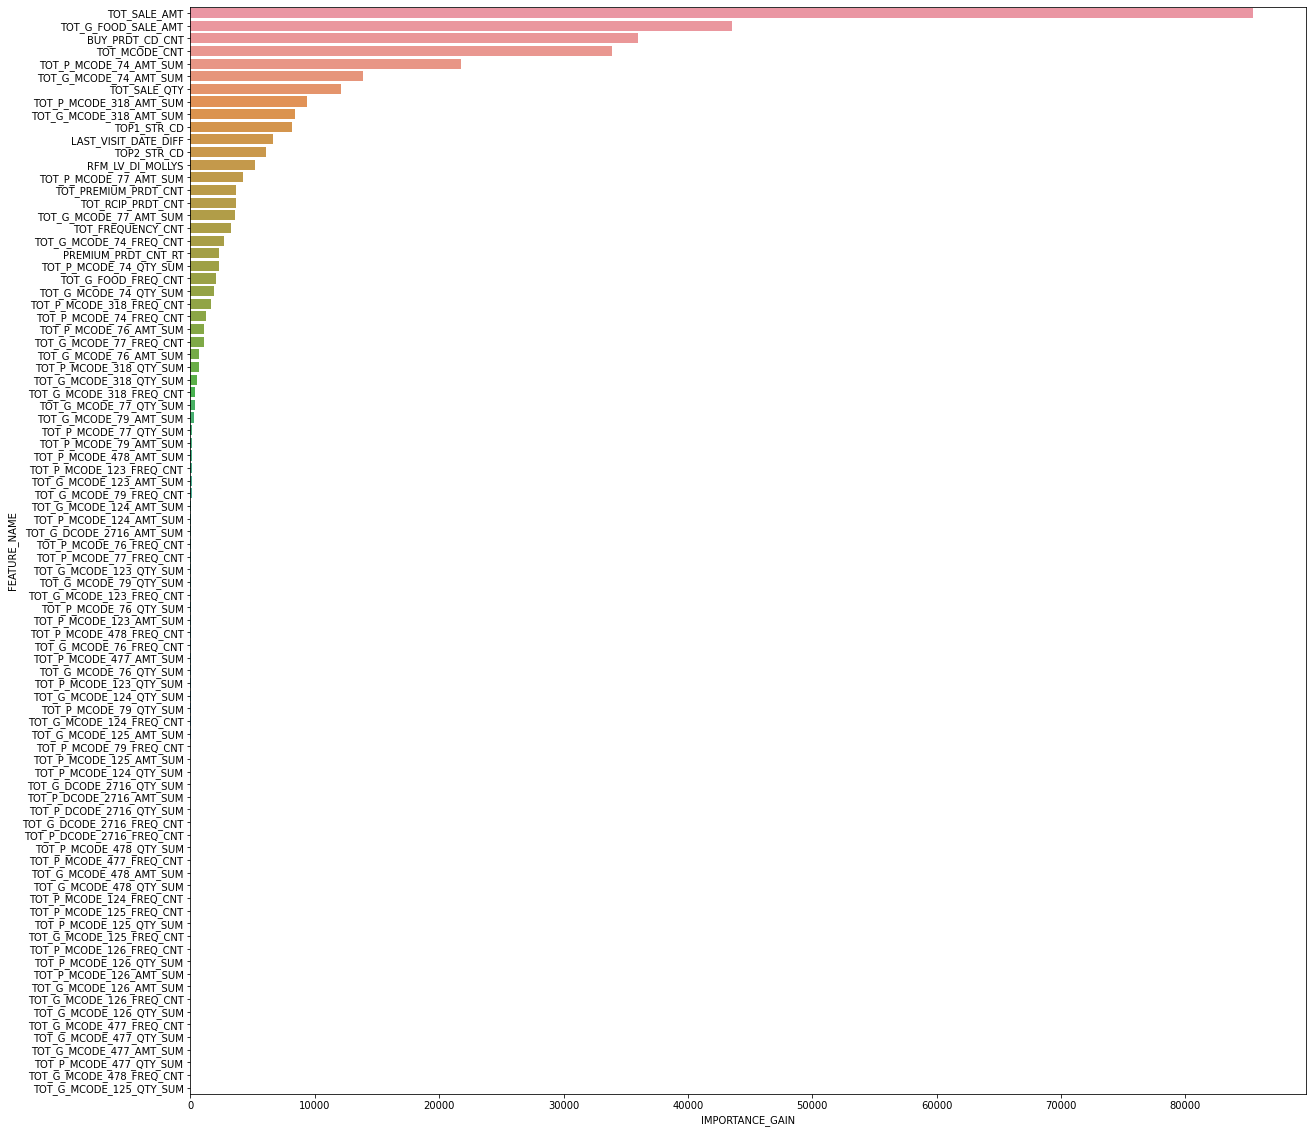

In [35]:
mdl_fi = clf_feature_importance('DOG_PREMIUM_FOOD_MODEL86_FEATURE.pkl')

['TOT_G_FOOD_FREQ_CNT', 'TOT_G_FOOD_SALE_AMT', 'LAST_VISIT_DATE_DIFF', 'TOT_FREQUENCY_CNT', 'TOT_RCIP_PRDT_CNT', 'TOT_PREMIUM_PRDT_CNT', 'PREMIUM_PRDT_CNT_RT', 'TOT_SALE_AMT', 'TOT_SALE_QTY', 'TOT_MCODE_CNT', 'BUY_PRDT_CD_CNT', 'RFM_LV_DI_MOLLYS', 'TOP1_STR_CD', 'TOP2_STR_CD', 'TOT_P_DCODE_2716_FREQ_CNT', 'TOT_P_DCODE_2716_QTY_SUM', 'TOT_P_DCODE_2716_AMT_SUM', 'TOT_G_DCODE_2716_AMT_SUM', 'TOT_G_DCODE_2716_FREQ_CNT', 'TOT_G_DCODE_2716_QTY_SUM', 'TOT_G_MCODE_79_FREQ_CNT', 'TOT_G_MCODE_79_QTY_SUM', 'TOT_G_MCODE_79_AMT_SUM', 'TOT_P_MCODE_79_AMT_SUM', 'TOT_P_MCODE_79_FREQ_CNT', 'TOT_P_MCODE_79_QTY_SUM', 'TOT_P_MCODE_123_FREQ_CNT', 'TOT_P_MCODE_123_QTY_SUM', 'TOT_P_MCODE_123_AMT_SUM', 'TOT_G_MCODE_123_AMT_SUM', 'TOT_G_MCODE_123_FREQ_CNT', 'TOT_G_MCODE_123_QTY_SUM', 'TOT_G_MCODE_124_FREQ_CNT', 'TOT_G_MCODE_124_QTY_SUM', 'TOT_G_MCODE_124_AMT_SUM', 'TOT_P_MCODE_124_AMT_SUM', 'TOT_P_MCODE_124_FREQ_CNT', 'TOT_P_MCODE_124_QTY_SUM', 'TOT_P_MCODE_125_FREQ_CNT', 'TOT_P_MCODE_125_QTY_SUM', 'TOT_P_MCOD

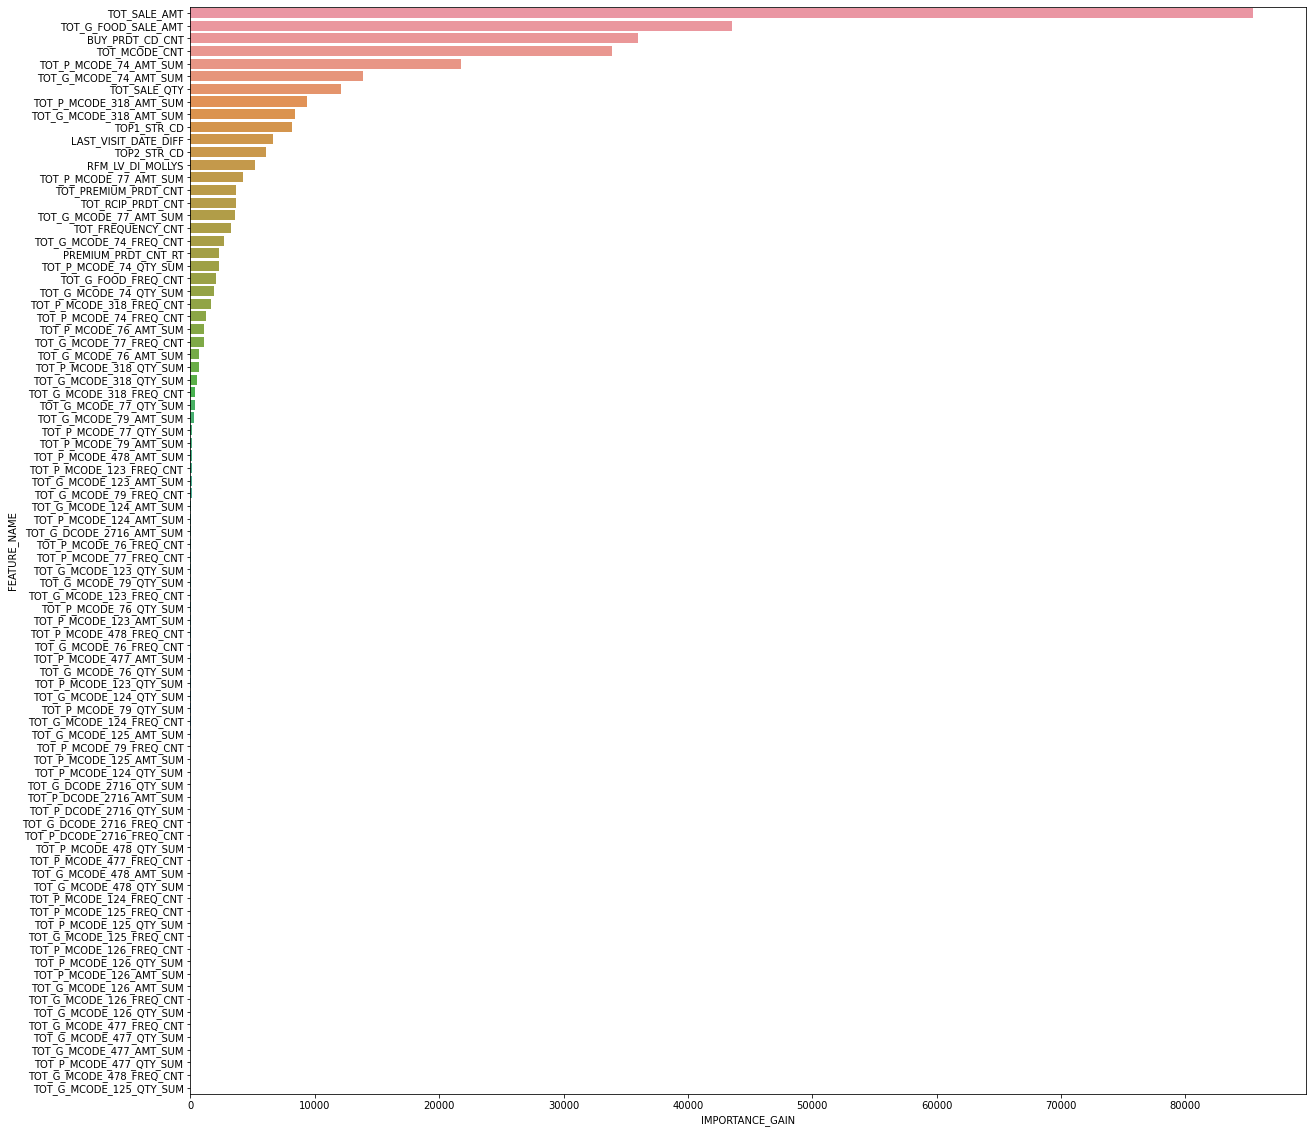

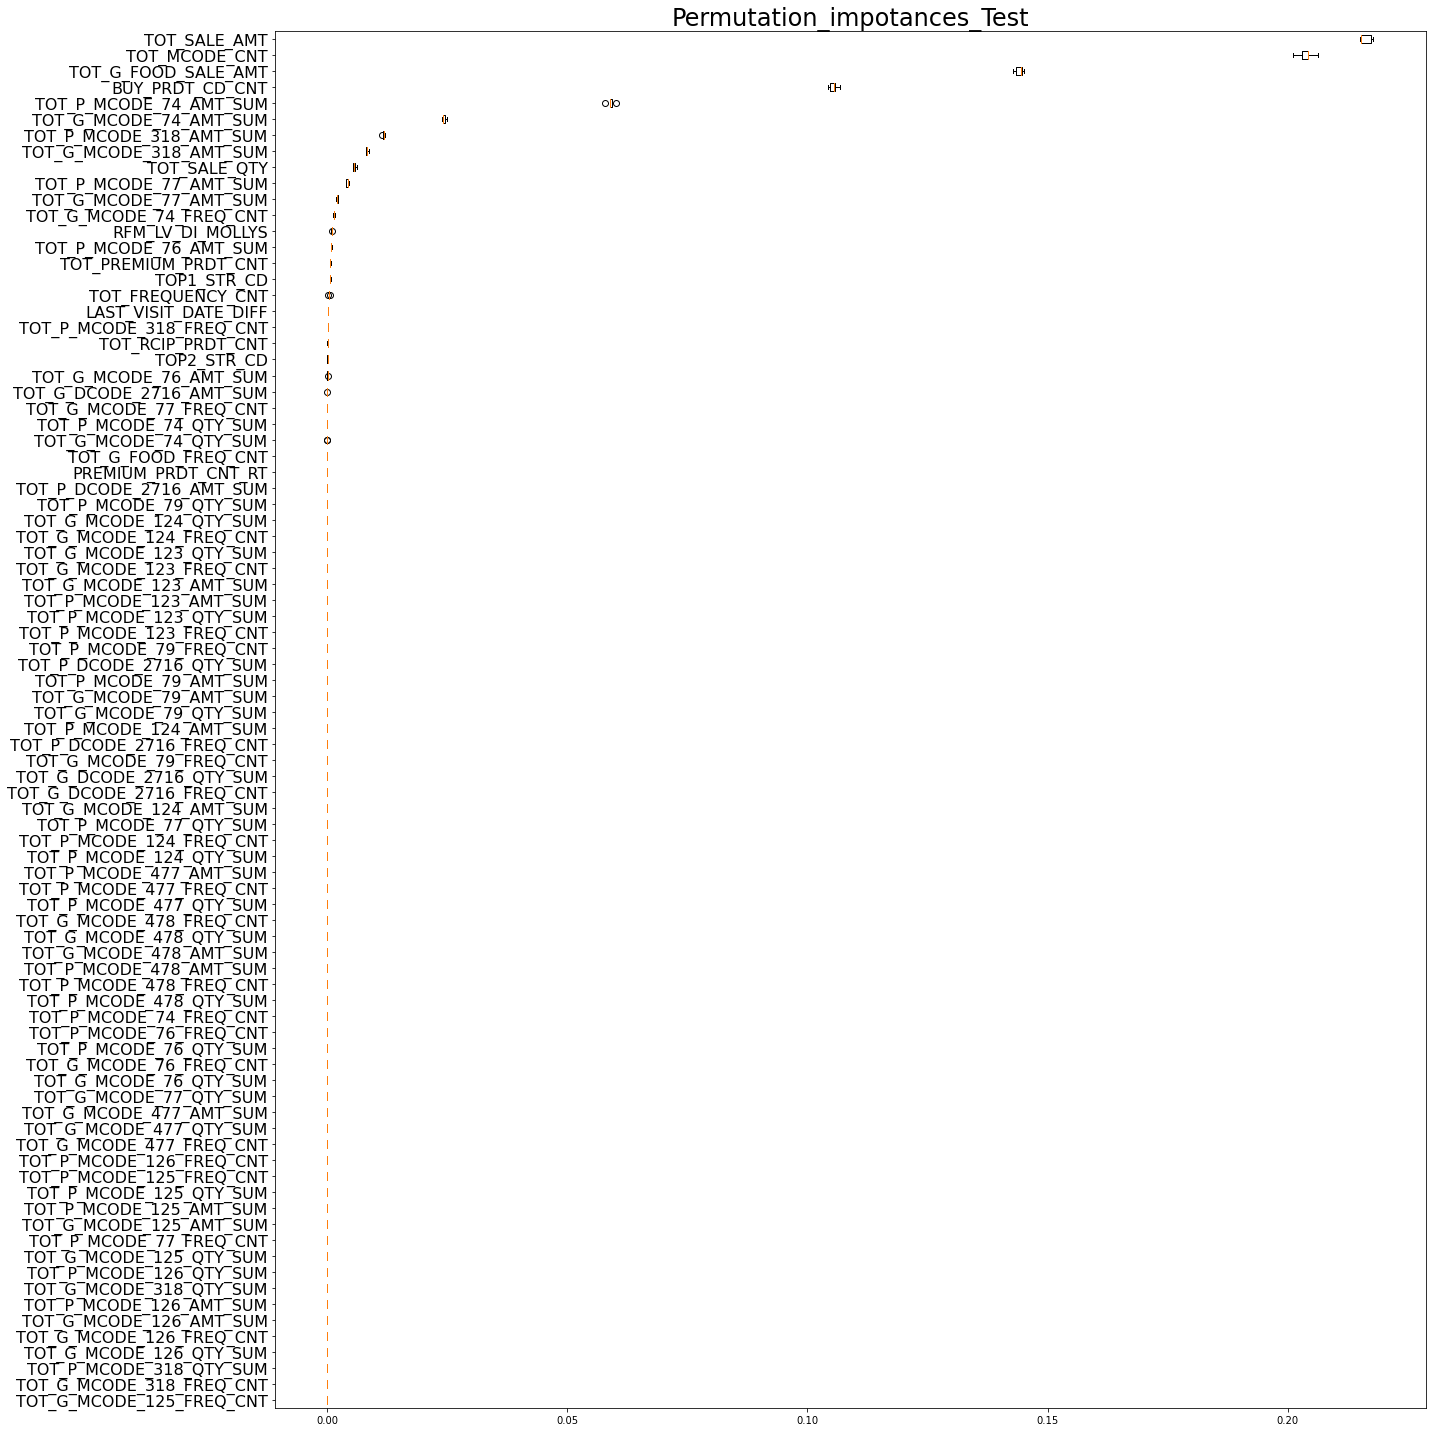

소요시간 : 60.0 초   ( 1 분 )



,FEATURE_NAME,IMPORTANCE_SPLIT,IMPORTANCE_GAIN,IMPORTANCE_PI,SPLIT_RANK,GAIN_RANK,PI_RANK
7,TOT_SALE_AMT,14512,85474.385172,0.216166,1.0,1.0,1.0
9,TOT_MCODE_CNT,3449,33879.709147,0.203784,13.0,4.0,2.0
1,TOT_G_FOOD_SALE_AMT,12768,43529.530632,0.144074,2.0,2.0,3.0
10,BUY_PRDT_CD_CNT,4005,35976.791983,0.105404,10.0,3.0,4.0
71,TOT_P_MCODE_74_AMT_SUM,8475,21738.469420,0.059016,3.0,5.0,5.0
70,TOT_G_MCODE_74_AMT_SUM,7476,13910.992149,0.024346,5.0,6.0,6.0
52,TOT_P_MCODE_318_AMT_SUM,4004,9366.526130,0.011741,11.0,8.0,7.0
53,TOT_G_MCODE_318_AMT_SUM,4885,8422.473142,0.008313,7.0,9.0,8.0
8,TOT_SALE_QTY,4354,12135.134164,0.005719,9.0,7.0,9.0
83,TOT_P_MCODE_77_AMT_SUM,2051,4203.287746,0.004273,18.0,14.0,10.0


In [39]:
def make_importance_df(fi_df,pi_df):
    pi_df.columns     = ['FEATURE_NAME','IMPORTANCE_PI']
    fi_all            = pd.merge(fi_df,pi_df,on=['FEATURE_NAME'])
    fi_all['PI_RANK'] = fi_all['IMPORTANCE_PI'].rank(ascending=False)
    fi_all            = fi_all.reindex(columns=['FEATURE_NAME','IMPORTANCE_SPLIT','IMPORTANCE_GAIN','IMPORTANCE_PI','SPLIT_RANK','GAIN_RANK','PI_RANK'])    
    fi_all.sort_values(by=['PI_RANK'])
    return fi_all

mdl_name = 'DOG_PREMIUM_FOOD_MODEL86_FEATURE.pkl'
mdl_fi = clf_feature_importance(mdl_name)
mdl_pi = PermutaionImportance(premium_model,X_train,Y_train)

mdl_all_pi = make_importance_df(mdl_fi,mdl_pi)


In [188]:
mdl_all_pi

,FEATURE_NAME,IMPORTANCE_SPLIT,IMPORTANCE_GAIN,IMPORTANCE_PI,SPLIT_RANK,GAIN_RANK,PI_RANK
0,LAST_VISIT_DATE_DIFF,45056,2.025951e+05,4.735367e-02,1.0,7.0,6.0
1,TOT_FREQUENCY_CNT,18580,1.022546e+05,2.256761e-02,10.0,9.0,7.0
2,TOT_RCIP_PRDT_CNT,20132,8.710510e+05,1.711822e-01,9.0,4.0,4.0
3,TOT_PREMIUM_PRDT_CNT,14382,6.385231e+04,1.103636e-02,13.0,12.0,9.0
4,PREMIUM_PRDT_CNT_RT,9424,2.267515e+04,2.005842e-03,14.0,15.0,15.0
5,TOT_SALE_AMT,43549,4.768802e+05,1.960258e-01,2.0,6.0,3.0
6,TOT_SALE_QTY,29755,2.150484e+06,3.046034e-01,6.0,1.0,2.0
7,TOT_MCODE_CNT,5435,4.065372e+04,4.880890e-03,16.0,14.0,12.0
8,BUY_PRDT_CD_CNT,15555,9.868539e+05,3.707973e-01,12.0,3.0,1.0
9,RFM_LV_DI_MOLLYS,34723,1.219490e+06,5.575820e-02,4.0,2.0,5.0
